In [0]:
import os
from Audio_reader import readtf
from getman import getmanlist
import gc
import numpy as np
import pandas as pd
import pickle
from keras.layers import Dense, Input, Dropout,Flatten,MaxPooling1D,SpatialDropout2D,SpatialDropout1D
from keras.layers import Conv1D, MaxPooling2D,BatchNormalization,Conv2D
from keras.models import Model
from keras.models import Sequential
from keras import optimizers
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import regularizers
from sklearn.metrics import confusion_matrix

In [0]:
def check(y):
    if 74 in y:
        return 0 
    #male
    if 1 in y:
        return 1
    #female
    if 2 in y:
        return 2
    #child
    if 3 in y:
        return 3
    return 0

In [0]:
X = []
Y = [] 
with open("X_list_eval.pickle","rb") as xf:
    X.extend(pickle.load(xf))
with open("Y_list_eval.pickle","rb") as xf:
    Y.extend(pickle.load(xf))
      
with open("X_list.pickle","rb") as xf:
    X.extend(pickle.load(xf))
with open("Y_list.pickle","rb") as xf:
    Y.extend(pickle.load(xf))

X=np.array(X)
X=np.reshape(X,(X.shape[0],X.shape[1],X.shape[2]))

Y=np.array(Y)  

X = X.astype('float32')    
X /= 255



In [0]:
learning_rate=0.001
decay=0.000001
momentum=0.99
dropout_rate_1 = 0.35

dropout_rate = 0.2

rglrzr = regularizers.l2(0.0003)

In [167]:

model = Sequential()

model.add(Conv1D(64, 3, padding='same',activation='relu',input_shape=X.shape[1:]))
model.add(BatchNormalization())
model.add(Conv1D(64, 3, padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=5,strides=2))
model.add(Dropout(rate=dropout_rate_1))


model.add(Conv1D(128, 3, padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3))
model.add(Dropout(rate=dropout_rate_1))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=dropout_rate))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=dropout_rate))


model.add(Dense(32,activation='relu'))
model.add(Dense(3,activation='softmax'))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_39 (Conv1D)           (None, 10, 64)            24640     
_________________________________________________________________
batch_normalization_135 (Bat (None, 10, 64)            256       
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 10, 64)            12352     
_________________________________________________________________
batch_normalization_136 (Bat (None, 10, 64)            256       
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 3, 64)             0         
_________________________________________________________________
dropout_111 (Dropout)        (None, 3, 64)             0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 3, 128)            24704     
__________

In [0]:

optimizer = optimizers.adam(lr=learning_rate,decay=decay)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [0]:
cb=[]

#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=0, mode='auto')
early_stopping = EarlyStopping(monitor='acc', min_delta=0, patience=30, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

#cb.append(reduce_lr)
cb.append(early_stopping)

In [0]:
history=model.fit(X, Y,
          batch_size=32,
          epochs=10,
          verbose=2,
          callbacks=cb,
          validation_split=0.25,
          shuffle=True)

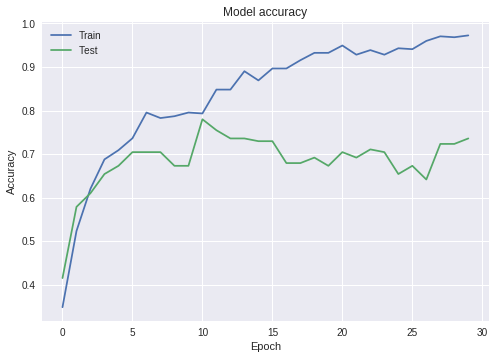

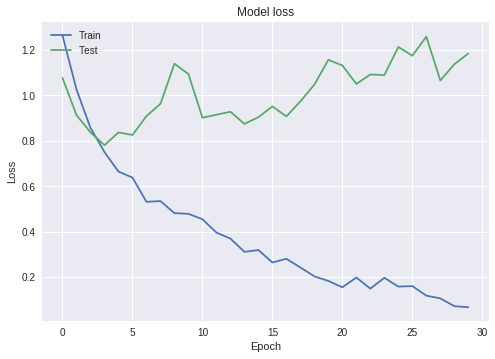

In [166]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
y_pred = model.predict(X)
def maxpos(li):
      if (li[1]>li[0]) and (li[1]>li[2])  :
        return 1
      if (li[2]>li[0]) and (li[2]>li[1])  :
        return 2     
      return 0
y_pre=[maxpos(y) for y in y_pred]
y_tes=[maxpos(y) for y in Y]

In [123]:
confusion_matrix(y_true=y_tes,y_pred=y_pre)

array([[118,   1,   6],
       [  8, 117,  11],
       [  3,   2, 367]])

In [0]:
model.save('MLP_75.model')